In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
import logging
warnings.filterwarnings('ignore')

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
from sklearn.manifold import TSNE
import tqdm
import nltk
from nltk.tokenize import sent_tokenize
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec

In [5]:
df = pd.read_csv('pre_processed_data.csv')

# WE ARE USING THESE REPEATEDLY SINCE ITS A NEW NOTEBBOOK -> DELETE THESE AND JUST CALL FUNCTIONS WHEN MERGED

In [6]:
# loading the pretrained model
model = Word2Vec.load('word2vec.model')

In [7]:
# let us compute the average of each recordes vector embedding to reduce the in accuracy in dimensionality per title using ht pretrained model
def compute_vect_avg_per_title(title):
    """
    title: str-> converts title to vector form using word2vec model
    """
    words = title.split()
    
    words = [word for word in words if word in model.wv.index_to_key]
    if not words:
        return np.zeros(150) 
    
    embeddings = [model.wv[word] for word in words]
    reduced_embedding = np.mean(embeddings, axis=0) # along columns
    
    return reduced_embedding# 1 row 150 cols

In [8]:
# generating VECTORIZED_TSD using the saved model -> word2vec model
df['vectorized_TSD'] = df['processed_TSD'].apply(compute_vect_avg_per_title)

In [9]:
df.head()

,Book_title,sub_title_book,description,merged_TSD,processed_TSD,vectorized_TSD
0,Software Engineering at Google,Lessons Learned from Programming Over Time,"Today, software engineers need to know not onl...",Software Engineering at Google Lessons Learned...,software engineering google lesson learned pro...,"[0.1280229, -0.07251548, -0.31772745, -0.14148..."
1,The Software Architect Elevator,Redefining the Architect's Role in the Digital...,As the digital economy changes the rules of th...,The Software Architect Elevator Redefining the...,software architect elevator redefining archite...,"[0.8097789, 0.26672482, 0.12788647, 0.32553503..."
2,Software Architecture Metrics,UNK,Software architecture metrics are key to the m...,Software Architecture Metrics UNK Software arc...,software architecture metric unk software arch...,"[0.6919463, -0.0041020163, -0.11713455, 0.4442..."
3,Designing Hexagonal Architecture with Java,Build maintainable and long-lasting applicatio...,UNK,Designing Hexagonal Architecture with Java Bui...,designing hexagonal architecture java build ma...,"[-0.00616907, 0.57498354, -0.23328787, 0.77813..."
4,OpenStack for Architects,Design production-ready private cloud infrastr...,UNK,OpenStack for Architects Design production-rea...,openstack architect design productionready pri...,"[1.6550393, -0.08286077, 0.35140345, 0.9059244..."


In [10]:
def lower_case(text): 
    return text.lower()

def remove_punctuations(text):
    no_punc_text = text.translate(str.maketrans('','',string.punctuation))
    return no_punc_text

def tokenize(text):
    return word_tokenize(text)

def remove_stopwords(text):
    stopset = set(stopwords.words('english'))
    return [word for word in text if word not in stopset]

def lemmatize_text(tokens):
    lemmer = WordNetLemmatizer()
    return [lemmer.lemmatize(word) if lemmer.lemmatize(word) is not None else word for word in tokens]

def remove_special_characters(tokens):
    return [re.sub('[^A-Za-z]+', '', word) for word in tokens]

In [11]:
# function to preprocess and convert the user prompt to vector
def get_vec(user_prompt):
    
    """
    This function cleans and converts the user prompts to its vector representation, each word in the prompt is searched for in the word2vec model. If the word is present,
    its respective vector is extracted. and if the word is not present, we use an array of zeros and the resultant vector is the average of the collection of the vectors
    to have an even representation of the vectors.
    """
    user_prompt = lower_case(user_prompt) # lower the text
    clean_text = remove_punctuations(user_prompt) # clean the text 
    tokens = tokenize(clean_text) # tokenization
    clean_tokens = remove_stopwords(tokens) # stopwords removal
    lemmas = lemmatize_text(clean_tokens) # lemmatization 
    final = remove_special_characters(lemmas) # removing special characters
    words = [word for word in final if word in model.wv.index_to_key] # filtering words that are in the model, rest are stored as zeros with same dim
    if not words:
        return np.zeros(150) 
    
    embeddings = [model.wv[word] for word in words] # using word2vec model
    reduced_embedding = np.mean(embeddings, axis=0) # along columns
    
    return reduced_embedding # 1 row 150 cols

# APPROACH 1 : DBSCAN (UNSUPERVISED SETTING)

In [12]:
from sklearn.cluster import DBSCAN

In [13]:
X = []
for array in df['vectorized_TSD']:
    X.append(array)

In [14]:
DBSCAN_model = DBSCAN(eps = 1.0, min_samples= 5, metric = 'euclidean')

In [15]:
DBSCAN_model.fit(X)

DBSCAN(eps=1.0)

In [16]:
# performance metrics (intrinsic)
from sklearn.metrics import silhouette_score
silhoutte_DBSCAN = silhouette_score(X,DBSCAN_model.labels_)
print('silhoutte score (DBSCAN): ', round(silhoutte_DBSCAN,4))

silhoutte score (DBSCAN):  -0.3306


- A negative silhoutte score suggests that the cluster labels assigned to data points are likely to be incorrect.

- it suggests that the distance to its assigned cluster point's is greater than its distance to the nearest neighbouring cluster point's

- Hence we do not consider DBSCAN for hyper parameter tuning as the score suggests that the clusters are not rightly arranged.

- Obviously, the silhoutte score can be subjected to the epsilon and minimum sample value to be cosidered which can argubly improve with hyper parameter tuning

# MODEL#1 - KMEANS CLUSTERING (UNSUPERVISED SETTING)

In [17]:
from sklearn.cluster import KMeans

In [18]:
# initial parameters
KM_model = KMeans(n_clusters= 10, verbose= 3, random_state= 42)

In [19]:
KM_model.fit(X)

Initialization complete
Iteration 0, inertia 2554430.6141721713.
Iteration 1, inertia 1623230.369368976.
Iteration 2, inertia 1598566.5782489984.
Iteration 3, inertia 1590687.4193658596.
Iteration 4, inertia 1587438.4390152325.
Iteration 5, inertia 1585467.9763884356.
Iteration 6, inertia 1583950.9654166524.
Iteration 7, inertia 1582791.9791651075.
Iteration 8, inertia 1581592.1137473313.
Iteration 9, inertia 1580407.8188001523.
Iteration 10, inertia 1579299.8366724434.
Iteration 11, inertia 1578402.3084630922.
Iteration 12, inertia 1577655.4965508399.
Iteration 13, inertia 1577059.300039734.
Iteration 14, inertia 1576568.7184778405.
Iteration 15, inertia 1576209.8706988022.
Iteration 16, inertia 1575974.4829517684.
Iteration 17, inertia 1575787.7515817296.
Iteration 18, inertia 1575626.4926940342.
Iteration 19, inertia 1575458.4315923187.
Iteration 20, inertia 1575327.1009691767.
Iteration 21, inertia 1575222.5441677636.
Iteration 22, inertia 1575148.7233148096.
Iteration 23, inertia 

KMeans(n_clusters=10, random_state=42, verbose=3)

In [20]:
KM_model.labels_

array([6, 7, 2, ..., 3, 3, 3])

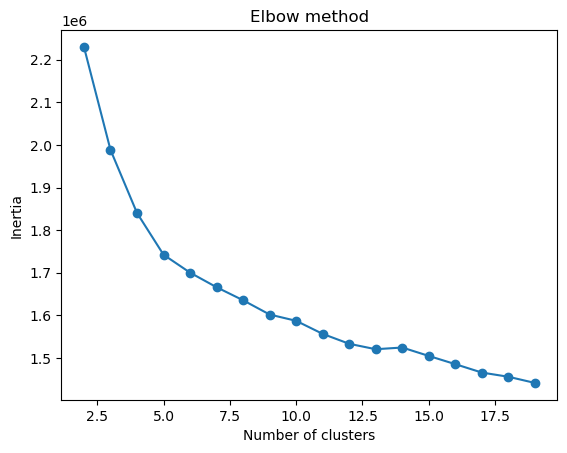

In [21]:
# lets use elbow method to get optimal number of clusters and further consider hyper parameter tuning to get the best set of values for parameters
# using high number of clusters considering 40k records

inertias = []

for i in range(2,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(range(2,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

As of the elbow method: 5 is the optimal number of clusters in our case

In [23]:
# lets us check metrics (inertia and shilloutte score)
print("Inertia: ", kmeans.inertia_)

Inertia:  1441020.2427587972


In [24]:
silhouette_Kmeans = silhouette_score(X, kmeans.labels_)
print("Silhouette Score (Kmeans):", round(silhouette_Kmeans, 4))

Silhouette Score (Kmeans): 0.0706


From the above scores: we infer the following things

- The Inertia Score of 123422.7 which is a very high number, suggests that the clusters formed are not very compact. the intra spatial arrangement of vectors with respect to their centers is huge.
- The shiloutte score of 0.07 suggests that the spatial distances of each cluster is not very good. 

In [25]:
# let us try hyper- parameter tuning and check if the results vary by any way.
param_grid_kmeans = {
    'n_clusters': [2, 3, 5, 7, 10],  
    'init': ['k-means++', 'random'],
    'max_iter': [200, 300, 500]  
}

In [26]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=KMeans(random_state=42), param_grid=param_grid_kmeans, cv=5, verbose = 2, return_train_score = True,)

In [27]:
grid_search.fit(X)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .........init=k-means++, max_iter=200, n_clusters=2; total time=   0.2s
[CV] END .........init=k-means++, max_iter=200, n_clusters=2; total time=   0.1s
[CV] END .........init=k-means++, max_iter=200, n_clusters=2; total time=   0.1s
[CV] END .........init=k-means++, max_iter=200, n_clusters=2; total time=   0.1s
[CV] END .........init=k-means++, max_iter=200, n_clusters=2; total time=   0.1s
[CV] END .........init=k-means++, max_iter=200, n_clusters=3; total time=   0.1s
[CV] END .........init=k-means++, max_iter=200, n_clusters=3; total time=   0.1s
[CV] END .........init=k-means++, max_iter=200, n_clusters=3; total time=   0.1s
[CV] END .........init=k-means++, max_iter=200, n_clusters=3; total time=   0.1s
[CV] END .........init=k-means++, max_iter=200, n_clusters=3; total time=   0.1s
[CV] END .........init=k-means++, max_iter=200, n_clusters=5; total time=   0.2s
[CV] END .........init=k-means++, max_iter=200,

GridSearchCV(cv=5, estimator=KMeans(random_state=42),
             param_grid={'init': ['k-means++', 'random'],
                         'max_iter': [200, 300, 500],
                         'n_clusters': [2, 3, 5, 7, 10]},
             return_train_score=True, verbose=2)

In [28]:
grid_search.best_params_

{'init': 'random', 'max_iter': 200, 'n_clusters': 10}

In [29]:
# checking the scores using the best params
kmeans_model_GS = KMeans(max_iter= 200, init= 'random', n_clusters = 10)

In [30]:
kmeans_model_GS.fit(X)

KMeans(init='random', max_iter=200, n_clusters=10)

In [31]:
print("Inertia: ", kmeans_model_GS.inertia_)

Inertia:  1573919.0626000972


In [32]:
silhouette_Kmeans = silhouette_score(X, kmeans_model_GS.labels_)
print("Silhouette Score (Kmeans_GS):", round(silhouette_Kmeans, 4))

Silhouette Score (Kmeans_GS): 0.1041


This is a much better result comparing to the dry run with no hyper -parameter tuning, the resultant score suggests that the intra cluster seperation is compact and cluster - cluster seperation is pretty spaced out. which means clusters are well defined.

This stays true to the nature of the data as well, as we are using books from multiple classes (Computer Science, Art, Life, Business etc) althought the number of classes may not be exactly same. 

let us try to make predictions using this approach

In [33]:
df['K_means_labels_GS'] = kmeans_model_GS.labels_

In [34]:
df.head()

,Book_title,sub_title_book,description,merged_TSD,processed_TSD,vectorized_TSD,K_means_labels_GS
0,Software Engineering at Google,Lessons Learned from Programming Over Time,"Today, software engineers need to know not onl...",Software Engineering at Google Lessons Learned...,software engineering google lesson learned pro...,"[0.1280229, -0.07251548, -0.31772745, -0.14148...",0
1,The Software Architect Elevator,Redefining the Architect's Role in the Digital...,As the digital economy changes the rules of th...,The Software Architect Elevator Redefining the...,software architect elevator redefining archite...,"[0.8097789, 0.26672482, 0.12788647, 0.32553503...",8
2,Software Architecture Metrics,UNK,Software architecture metrics are key to the m...,Software Architecture Metrics UNK Software arc...,software architecture metric unk software arch...,"[0.6919463, -0.0041020163, -0.11713455, 0.4442...",5
3,Designing Hexagonal Architecture with Java,Build maintainable and long-lasting applicatio...,UNK,Designing Hexagonal Architecture with Java Bui...,designing hexagonal architecture java build ma...,"[-0.00616907, 0.57498354, -0.23328787, 0.77813...",1
4,OpenStack for Architects,Design production-ready private cloud infrastr...,UNK,OpenStack for Architects Design production-rea...,openstack architect design productionready pri...,"[1.6550393, -0.08286077, 0.35140345, 0.9059244...",1


In [35]:
def recommend_books(user_prompt, model, df):
    #book_titles,#words, #threshold -> commenting out, these are parameters to consider too, experimenting

    """
    Takes the user prompt, converts it to vector and fits it to the model
    
    Params: 
    User_prompt: str -> the text user enters
    nn_model: model used for prediction of user prompt
    word_list = list -> list of words that are used in model= word2vec
    recommended_words-> list: list of words that are most similar to the 
    #book_titles:list-> list of book titles
    threshold-> accepted threshold for titles (used for getting the titles which has most words from the recommended words which are above the threshold)
    df -> To retrieve the titles recommended by the model
    """    
    # converting the user prompt to a vector
    user_prompt_embedding = get_vec(user_prompt).reshape(1,150) # here reshape is required!

#     threshold = threshold

    # nearest neighbours- feeding the vectored prompt
    distances, indices = model.kneighbors(user_prompt_embedding)
    

    # Retrieve the book titles that corresponding to the user prompt as per nearest neigbour (using cosine similarity)
    recommended_titles = [df.Book_title.iloc[i] for i in indices[0]]
        
#     filtered_titles = []
    
#     for title in book_titles:
#         title_words = title.split()
        
#         common_words = sum(1 for word in title_words if word in recommended_words)
#         common_ratio = common_words / len(title_words)
#         print(f"Title: {title}, Common words: {common_words}, Common ratio: {common_ratio}")
#         if common_ratio >= threshold:
#             filtered_titles.append(title)
#     return filtered_titles
    return recommended_titles

In [36]:
def get_recommended_books_Kmeans_GS(user_prompt, model, df):
    
    user_prompt_embedding = get_vec(user_prompt).reshape(1,150).astype('float64')
    print(user_prompt_embedding)
    print(user_prompt_embedding.dtype)
    
    predicted_label = model.fit_predict(user_prompt_embedding)
    print(predicted_label)
    
    # querying out the labels matching the predicted label
    predicted_titles_df = df.query(f'K_means_labels_GS == {predicted_label}')
    print(predicted_titles_df[:2])
    
    # helper function
    # to find the cosine similarity of vectors with the embeddings
    def find_cosine_with_target(target_embedding, book_embeddings, threshold):
        matching_indices = []
        for i, book_embedding in enumerate(book_embeddings):
        # cosine similarity
            similarity = np.dot(target_embedding, book_embedding) / (np.linalg.norm(target_embedding) * np.linalg.norm(book_embedding))
            if similarity >= threshold:
                matching_indices.append(i)
        return matching_indices
    
    # get the indices of matching labels where the cosine similarity is above threshold
    book_embeddings = [x for x in df['vectorized_TSD']]
    indices = find_cosine_with_target(user_prompt_embedding, book_embeddings, threshold = 0.7)
    
    matched_titles = [] 
    for index in indices:
        matched_titles.append(df['Book_title'].iloc[index])
        
    return matched_titles[:5]

In [37]:
user_prompt = 'hey! i want a book to learn python'
get_recommended_books_Kmeans_GS(user_prompt, model= kmeans_model_GS, df = df)

[[-0.68306226  0.26253751 -0.73265982 -1.07627892  0.37533593  1.3929081
  -0.01708098 -0.40043807 -1.40442598 -0.29700333  0.61931986  0.51207477
  -1.28521621 -0.86944693  0.217545    0.12313233  1.60475087 -1.55045331
  -0.01897044  1.14260447  0.47379595  0.21079883 -1.98774338 -0.13580973
  -0.65328264 -0.12351771 -0.01579081 -1.84366059  0.22386317  0.48657051
   0.9877038   1.02192771 -1.71731031  0.01141509 -0.23784828 -1.69769979
  -0.46559134  0.74044156 -0.57492846  0.19826458  0.31344563 -0.55632365
  -2.03781986 -0.23880401  0.59947902  0.28590339 -0.56297314  0.64080238
   0.71406567  1.16174579 -0.50473988 -0.11360459  0.79517567  0.52363431
   0.98186046 -0.39539295 -0.37705073  0.61796427 -0.93541181 -0.35675281
  -0.15078755  1.27696896  0.07780632 -1.9421699   2.27339077  1.18008673
  -1.40983295 -1.05877745 -0.92244816  0.29140401  0.60833013  0.29723746
  -0.63470668 -0.63213539  0.5571413   0.56096488  0.77376091  0.62102485
  -1.08250403 -0.80383718 -0.59186876 -

ValueError: n_samples=1 should be >= n_clusters=10.

# IGNORE THE ABOVE APPROACH (DISCARDED), BUT CAN MENTION SCORES AS AN ATTEMPT>

# APPROACH#2 - Support Vector Classifier (SUPERVISED SETTING)

In [39]:
df_original = pd.read_csv('scrapped_data_version_1_comp_business_mind.csv')
labels = df_original.category_verification
df['true_labels'] = labels

In [46]:
df.head()

,Book_title,sub_title_book,description,merged_TSD,processed_TSD,vectorized_TSD,K_means_labels_GS,true_labels
0,Software Engineering at Google,Lessons Learned from Programming Over Time,"Today, software engineers need to know not onl...",Software Engineering at Google Lessons Learned...,software engineering google lesson learned pro...,"[0.1280229, -0.07251548, -0.31772745, -0.14148...",0,arch
1,The Software Architect Elevator,Redefining the Architect's Role in the Digital...,As the digital economy changes the rules of th...,The Software Architect Elevator Redefining the...,software architect elevator redefining archite...,"[0.8097789, 0.26672482, 0.12788647, 0.32553503...",8,arch
2,Software Architecture Metrics,UNK,Software architecture metrics are key to the m...,Software Architecture Metrics UNK Software arc...,software architecture metric unk software arch...,"[0.6919463, -0.0041020163, -0.11713455, 0.4442...",5,arch
3,Designing Hexagonal Architecture with Java,Build maintainable and long-lasting applicatio...,UNK,Designing Hexagonal Architecture with Java Bui...,designing hexagonal architecture java build ma...,"[-0.00616907, 0.57498354, -0.23328787, 0.77813...",1,arch
4,OpenStack for Architects,Design production-ready private cloud infrastr...,UNK,OpenStack for Architects Design production-rea...,openstack architect design productionready pri...,"[1.6550393, -0.08286077, 0.35140345, 0.9059244...",1,arch


In this approach, we will try to induce supervised learning on our data, considering vectorised title + Sub_title + Description to be the feature set and true_labels to be the independent feature. 

In this context this turns out to be a multi class classification use case where the number of classes are the unique count of true labels. In our case, 11 classes.

In [79]:
# pre-processing the true_labels column - label encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score

In [63]:
encoder = LabelEncoder()

In [64]:
encoded_labels = encoder.fit_transform(df['true_labels'])

In [65]:
# Checking the encoding
encoded_labels [:4]

array([4, 4, 4, 4])

In [66]:
# encoded labels column
df['encoded_labels'] = encoded_labels

In [67]:
df.head()

,Book_title,sub_title_book,description,merged_TSD,processed_TSD,vectorized_TSD,K_means_labels_GS,true_labels,encoded_labels
0,Software Engineering at Google,Lessons Learned from Programming Over Time,"Today, software engineers need to know not onl...",Software Engineering at Google Lessons Learned...,software engineering google lesson learned pro...,"[0.1280229, -0.07251548, -0.31772745, -0.14148...",0,arch,4
1,The Software Architect Elevator,Redefining the Architect's Role in the Digital...,As the digital economy changes the rules of th...,The Software Architect Elevator Redefining the...,software architect elevator redefining archite...,"[0.8097789, 0.26672482, 0.12788647, 0.32553503...",8,arch,4
2,Software Architecture Metrics,UNK,Software architecture metrics are key to the m...,Software Architecture Metrics UNK Software arc...,software architecture metric unk software arch...,"[0.6919463, -0.0041020163, -0.11713455, 0.4442...",5,arch,4
3,Designing Hexagonal Architecture with Java,Build maintainable and long-lasting applicatio...,UNK,Designing Hexagonal Architecture with Java Bui...,designing hexagonal architecture java build ma...,"[-0.00616907, 0.57498354, -0.23328787, 0.77813...",1,arch,4
4,OpenStack for Architects,Design production-ready private cloud infrastr...,UNK,OpenStack for Architects Design production-rea...,openstack architect design productionready pri...,"[1.6550393, -0.08286077, 0.35140345, 0.9059244...",1,arch,4


In [68]:
# extracting independent and dependent features
X = [x for x in df['vectorized_TSD']]
y = df['encoded_labels']

In [71]:
# splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42, stratify=y)

In [72]:
# importing SVC
from sklearn.svm import SVC
# initial instance with fundamental parameters
model_SVC = SVC(verbose= 2,decision_function_shape= 'ovr', random_state= True)

In [77]:
model_SVC.fit(X_train,y_train)

[LibSVM]

SVC(random_state=True, verbose=2)

In [114]:
def calculate_scores(model, X_tr, X_ts, y_tr, y_ts):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print('The Accuracy of the Model for trainig set is: ',round(accuracy_score(y_train, y_pred_train),4))
    #print('The Precision of the Model for trainig set is: ',round(precision_score(y_train, y_pred_train),4))
    print('The Classification report for training set:')
    print(classification_report(y_train, y_pred_train))
    
    
    print('The Accuracy of the Model for test set is: ',round(accuracy_score(y_test, y_pred_test),4))
   # print('The Precision of the Model for test set is: ',round(precision_score(y_test, y_pred_test),4))
    print('The Classification report for test set:')
    print(classification_report(y_test, y_pred_test))
    
    # confusion matrix
    train_cm = confusion_matrix(y_train, y_pred_train)
    test_cm = confusion_matrix(y_test, y_pred_test)
    
    fig, ax = plt.subplots(2,1, figsize = (7, 10))
    
    sns.heatmap(train_cm, fmt = 'd', cmap = 'Oranges', ax = ax[0], annot= True)
    ax[0].set_title('Confusion Matrix (Train set): ')
    ax[0].set_xlabel('Predicted Labels')
    ax[0].set_ylabel('True Labels')
    
    
    sns.heatmap(test_cm, fmt = 'd', cmap = 'Blues', ax = ax[1], annot= True)
    ax[1].set_title('Confusion Matrix (Test set): ')
    ax[1].set_xlabel('Predicted Labels')
    ax[1].set_ylabel('True Labels')

The Accuracy of the Model for trainig set is:  0.8162
The Classification report for training set:
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      5117
           1       0.77      0.66      0.71      1233
           2       0.69      0.77      0.73      3240
           3       0.89      0.70      0.78      1004
           4       0.77      0.16      0.27       294
           5       0.93      0.95      0.94      5593
           6       0.68      0.36      0.47       837
           7       0.96      0.98      0.97      5593
           8       0.75      0.77      0.76      2579
           9       0.73      0.63      0.68       759
          10       0.71      0.63      0.67      3889

    accuracy                           0.82     30138
   macro avg       0.79      0.68      0.71     30138
weighted avg       0.81      0.82      0.81     30138

The Accuracy of the Model for test set is:  0.7673
The Classification report for test set

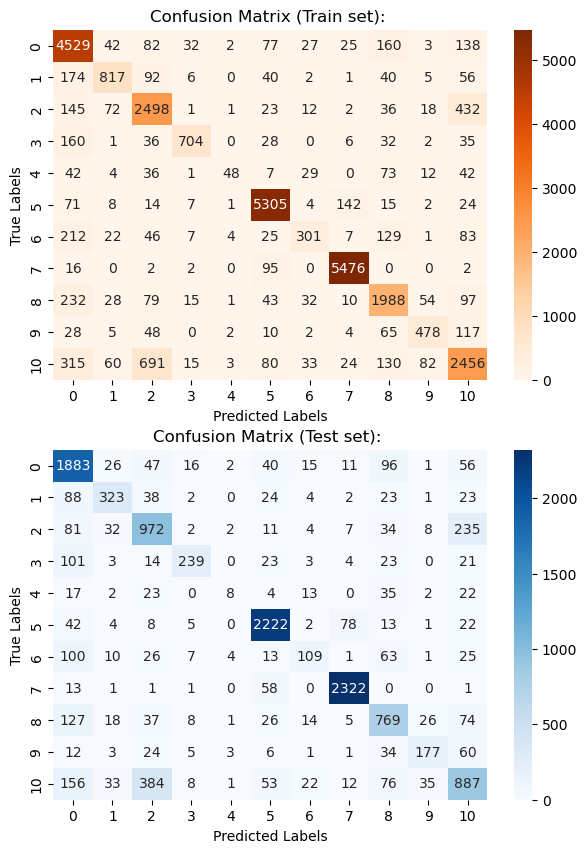

In [117]:
calculate_scores(model = model_SVC, X_tr= X_train, X_ts= X_test,y_tr= y_train,y_ts= y_test)

We see that the train accuracy is about 81% and test accuracy is about 76%, suggesting some over-fit of data.

Although an overfit, this is still considered a pretty decent model.

Let us try to improve the model using Hyper Parameter Tuning

We are going to implement a different, much quicker and easy on the computational power Hyper Parameter tuning API called **Halving Random Search**

`HalvingGridSearch` and `HalvingRandomSearch` take a different approach called successive halving. 

HGS is like a competition among all candidates (hyperparameter combinations). In the first iteration, HGS trains all candidates on a small proportion of the training data. In the next iteration, only the candidates which performed best are chosen and they will be given more resources to compete. So, with each passing iteration, the ‘surviving’ candidates will be given more and more resources (training samples) until the best set of hyperparameters are left standing.

This has been known to increase the overall performance in roughly 10% of the time consumed by `GridSearchCV` or `RandomizedSearchCV`

In [125]:
# using randomised_search

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [129]:
param_grid_svc = {
    'C': [0.1, 1, 10, 50, 100],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel choice
    'degree': [2, 3, 4, 5],  # Degree of the polynomial kernel (only for 'poly' kernel)
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

In [130]:
halving_grid_search = HalvingGridSearchCV(estimator=SVC(random_state= 42),
                                          param_grid= param_grid_svc,
                                          cv=10,
                                          factor= 3, 
                                          scoring = 'accuracy',
                                          return_train_score = True,
                                          n_jobs = -1
                                         )

In [135]:
%timeit
halving_grid_search.fit(X_train, y_train)

HalvingGridSearchCV(cv=10, estimator=SVC(random_state=42), n_jobs=-1,
                    param_grid={'C': [0.1, 1, 10, 50, 100],
                                'degree': [2, 3, 4, 5],
                                'gamma': ['scale', 'auto'],
                                'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
                    scoring='accuracy')

In [136]:
halving_grid_search.best_params_

{'C': 10, 'degree': 5, 'gamma': 'auto', 'kernel': 'rbf'}

In [142]:
# results
df_results_HGS = pd.DataFrame(halving_grid_search.cv_results_)
df_results_HGS.to_csv('Results_HGS.csv',index_label= False)

In [140]:
df_results_HGS

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_gamma,param_kernel,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0,372,0.019498,0.003668,0.002300,0.001100,0.1,2,scale,linear,...,0.985030,0.964072,0.982036,0.991018,0.976048,0.985030,0.979042,0.976048,0.979940,0.006834
1,0,372,0.014314,0.001837,0.002197,0.000744,0.1,2,scale,poly,...,0.335329,0.314371,0.365269,0.467066,0.329341,0.317365,0.317365,0.344311,0.347006,0.042710
2,0,372,0.018203,0.003496,0.018599,0.019365,0.1,2,scale,rbf,...,0.380240,0.410180,0.488024,0.559880,0.428144,0.446108,0.458084,0.479042,0.451198,0.060105
3,0,372,0.015901,0.002801,0.002202,0.000395,0.1,2,scale,sigmoid,...,0.365269,0.485030,0.526946,0.547904,0.488024,0.446108,0.500000,0.437126,0.469162,0.058549
4,0,372,0.012701,0.002280,0.001800,0.000749,0.1,2,auto,linear,...,0.985030,0.964072,0.982036,0.991018,0.976048,0.985030,0.979042,0.976048,0.979940,0.006834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,3,10044,19.347701,3.126963,6.138346,6.638642,10,2,scale,rbf,...,0.974887,0.976214,0.975108,0.975218,0.975993,0.977763,0.976989,0.972563,0.975384,0.001381
236,3,10044,21.433138,1.368333,4.058921,0.621631,10,4,scale,rbf,...,0.974887,0.976214,0.975108,0.975218,0.975993,0.977763,0.976989,0.972563,0.975384,0.001381
237,3,10044,20.195603,3.458649,4.361207,0.706573,10,5,scale,rbf,...,0.974887,0.976214,0.975108,0.975218,0.975993,0.977763,0.976989,0.972563,0.975384,0.001381
238,4,30132,196.453256,7.501686,49.603225,51.978526,10,5,auto,rbf,...,0.899771,0.900361,0.898739,0.899661,0.900583,0.901468,0.899775,0.898079,0.899602,0.001080


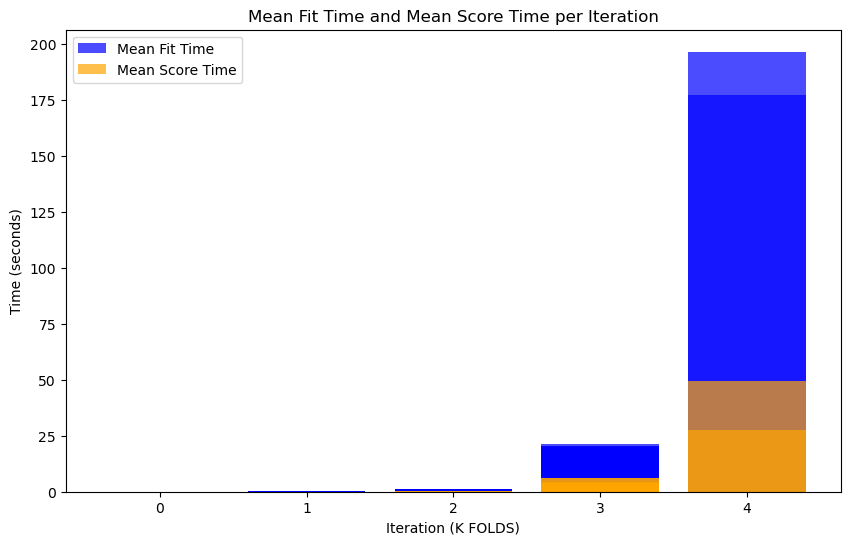

In [153]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(df_results_HGS['iter'], df_results_HGS['mean_fit_time'], label='Mean Fit Time', color='blue', alpha=0.7)
plt.bar(df_results_HGS['iter'], df_results_HGS['mean_score_time'], label='Mean Score Time', color='orange', alpha=0.7)
plt.xlabel('Iteration (K FOLDS)')
plt.ylabel('Time (seconds)')
plt.title('Mean Fit Time and Mean Score Time per Iteration')
plt.legend()
plt.show()

As the algorithm works with successive elimination of weak parameters, the initial fit and score time is seen to be close to 0, for each fold the time increases gradually.
spiking at the 4th iteration with the best parameters being deduced, This depicted in the above bar chart

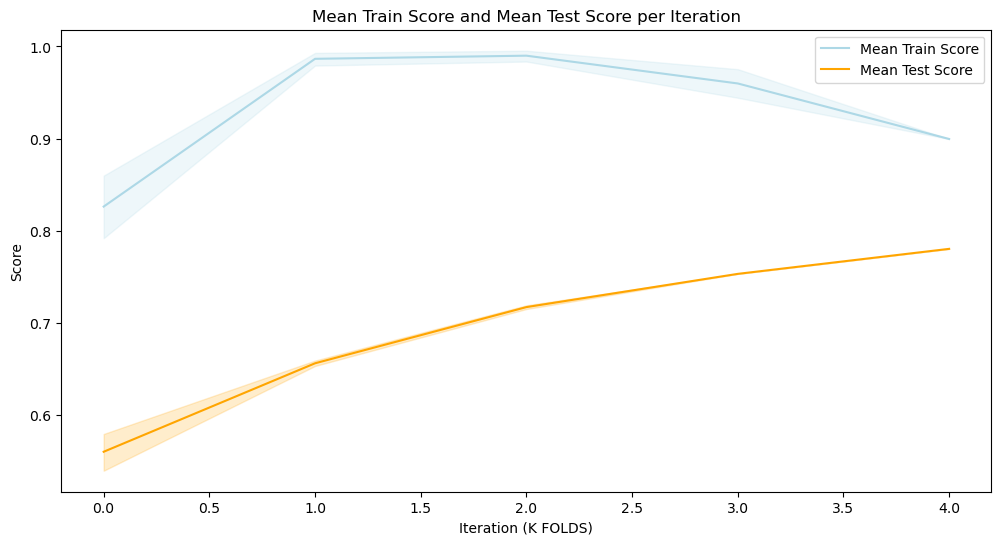

In [157]:
plt.figure(figsize=(12,6))
sns.lineplot(x = df_results_HGS.iter, y = df_results_HGS.mean_train_score, markers= '.', color = 'lightblue',label='Mean Train Score')
sns.lineplot(x = df_results_HGS.iter, y = df_results_HGS.mean_test_score, markers= '.', color = 'orange',label='Mean Test Score')
plt.xlabel('Iteration (K FOLDS)')
plt.ylabel('Score')
plt.title('Mean Train Score and Mean Test Score per Iteration')
plt.legend()
plt.show()

The above line plot suggests that:
- the train score was initially at a very good point, had a steady spike and then lowered to a central space. The steady spike can say that the model was over generalizing on the data and was almost as good as getting 100% accurate predictions which is considered overfit. in the later stages the line saw a negative trend showing significant poor performance on the final iterations on unseen or seen data.
- The test score was terrible and gradually increased with each iteration. we notice no spike in the test score line suggesting that the learning rate of the model was gradual and steady resulting in no sudden over generalization of the data.
- both the points met a close space to each other, where train score line was slightly above test score line, suggesting that the best parameter model slightly overfits. we can confirm this later based on the predictions made using best_params_ estimator
    

In [160]:
SVC_RS_model = SVC(C= 10, degree= 5, gamma= 'auto', kernel='rbf', random_state= 42, decision_function_shape= 'ovr')

In [161]:
SVC_RS_model.fit(X_train, y_train)

SVC(C=10, degree=5, gamma='auto', random_state=42)

The Accuracy of the Model for trainig set is:  0.8974
The Classification report for training set:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      5117
           1       0.86      0.84      0.85      1233
           2       0.79      0.86      0.82      3240
           3       0.94      0.85      0.89      1004
           4       0.90      0.60      0.72       294
           5       0.97      0.97      0.97      5593
           6       0.87      0.78      0.82       837
           7       0.98      0.99      0.98      5593
           8       0.86      0.88      0.87      2579
           9       0.85      0.79      0.82       759
          10       0.83      0.76      0.80      3889

    accuracy                           0.90     30138
   macro avg       0.89      0.84      0.86     30138
weighted avg       0.90      0.90      0.90     30138

The Accuracy of the Model for test set is:  0.7804
The Classification report for test set

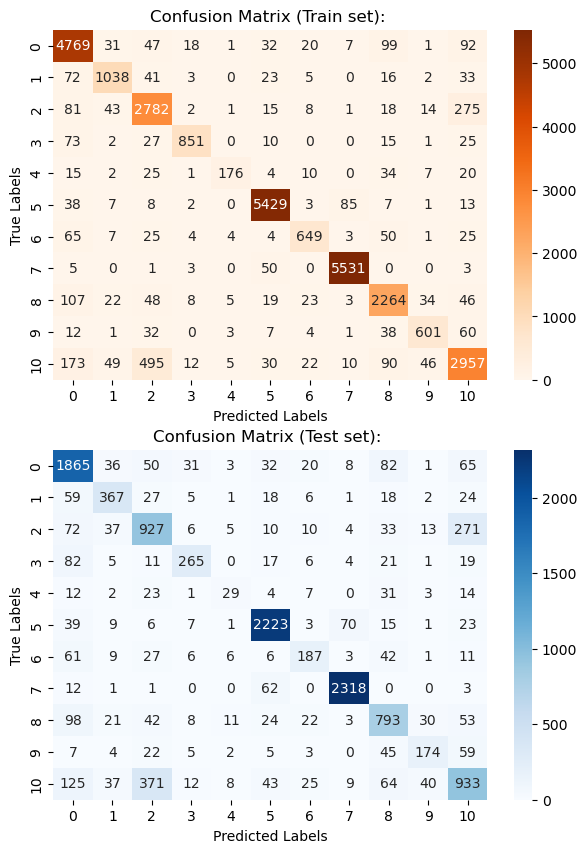

In [162]:
calculate_scores(model = SVC_RS_model, X_tr= X_train, X_ts= X_test,y_tr= y_train,y_ts= y_test)

**Judging purely on Accuracy, the model with best parameters after halving search CV did not perform good. instead was even worse than the original fundamental model.**

 Reasons to this could be:
- 
- 
- 


In [165]:
# since the fundamental model was a much more stable one, we proceed with using it for our final product (inference engine)
# we are using the fundamental set model to predict the labels which will later be utilized to get best recommended books.
X_total = [x for x in df['vectorized_TSD']]
final_labels_SVC = model_SVC.predict(X_total)

In [168]:
df.columns

Index(['Book_title', 'sub_title_book', 'description', 'merged_TSD',
       'processed_TSD', 'vectorized_TSD', 'K_means_labels_GS', 'true_labels',
       'encoded_labels', 'SVC_Labels'],
      dtype='object')

In [170]:
df['SVC_Labels'] = final_labels_SVC

In [177]:
# checking the final accuracy on the whole dataset (encoded labels vs SVC_labels)
print('The accuracy of the fundamental model on full dataset (40K records) is: ', round(accuracy_score(df['encoded_labels'], df['SVC_Labels']),4))

The accuracy of the fundamental model on full dataset (40K records) is:  0.8016


In [183]:
def get_recommended_books_VER2_(user_prompt, model, df):
    
    user_prompt_embedding = get_vec(user_prompt).reshape(1,150).astype('float64')
    
    
    predicted_label = model.predict(user_prompt_embedding)
    
    
    # querying out the labels matching the predicted label
    predicted_titles_df = df.query(f'SVC_Labels == {predicted_label}')
    
    # helper function
    # to find the cosine similarity of vectors with the embeddings
    def find_cosine_with_target(target_embedding, book_embeddings, threshold):
        matching_indices = []
        for i, book_embedding in enumerate(book_embeddings):
        # cosine similarity
            similarity = np.dot(target_embedding, book_embedding) / (np.linalg.norm(target_embedding) * np.linalg.norm(book_embedding))
            if similarity >= threshold:
                matching_indices.append(i)
        return matching_indices
    
    # get the indices of matching labels where the cosine similarity is above threshold
    book_embeddings = [x for x in df['vectorized_TSD']]
    indices = find_cosine_with_target(user_prompt_embedding, book_embeddings, threshold = 0.7)
    
    matched_titles = [] 
    for index in indices:
        matched_titles.append(df['Book_title'].iloc[index])
        
    return matched_titles[:10]

In [184]:
user_prompt = 'Hey! i want to learn python'
get_recommended_books_VER2_(user_prompt, model= model_SVC, df = df)

['Rust Quick Start Guide',
 'Machine Learning with Python for Everyone',
 'Mastering Python',
 'Rust Quick Start Guide',
 'Python for Professionals',
 "jMonkeyEngine 3.0 : Beginner's Guide",
 'Quick Python 3',
 'Learn Python in 7 Days',
 'Learn ECMAScript',
 'Exploring Swift Playgrounds']